### To analyse a twitter dataset of tweets

In [139]:
import re
import nltk
import string
from sklearn.pipeline import Pipeline
from joblib import dump
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report

#### The dataset is a CSV file consisting of 1600000 tweets

In [140]:
DATASET_ENCODING = "ISO-8859-1"
DATASET_COLUMNS=['target','ids','date','flag','user','text']
tweets=pd.read_csv("tweets.csv",encoding=DATASET_ENCODING,names=DATASET_COLUMNS)

In [141]:
tweets.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


#### Check whether dataset is balanced

In [142]:
tweets['target'].value_counts()

4    800000
0    800000
Name: target, dtype: int64

#### Check for null values

In [143]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [144]:
tweets.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [145]:
len(tweets)

1600000

#### Check if dataset is balanced

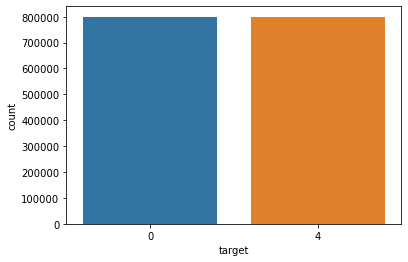

In [146]:
sns.countplot(x='target',data=tweets)

#### Negative sentiments in the dataset are labelled 0 and positive sentiments are labelled 4.Replace 4 with 1

In [147]:
tweets['target']=tweets['target'].replace(4,1)

In [148]:
tweets['target'].value_counts()

1    800000
0    800000
Name: target, dtype: int64

In [149]:
tweets_pos=tweets[tweets['target']==1]
tweets_neg=tweets[tweets['target']==0]

#### Reduce the tweets to 40000 for faster analysis by taking 20000 posittive tweets and 20000 negative tweets

In [150]:
tweets_pos=tweets_pos.iloc[:20000]
tweets_neg=tweets_neg.iloc[:20000]

In [151]:
tweets_neg

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
19995,0,1556975331,Sun Apr 19 01:19:14 PDT 2009,NO_QUERY,TOMurdockPapers,"Not much time off this weekend, work trip to M..."
19996,0,1556976068,Sun Apr 19 01:19:30 PDT 2009,NO_QUERY,nikibennn,One more day of holidays
19997,0,1556976167,Sun Apr 19 01:19:32 PDT 2009,NO_QUERY,eifflesummer,feeling so down right now .. i hate you DAMN H...
19998,0,1556976222,Sun Apr 19 01:19:34 PDT 2009,NO_QUERY,lomobabes,"geez,i hv to READ the whole book of personalit..."


In [152]:
tweets=pd.concat([tweets_pos,tweets_neg],ignore_index=True)

In [153]:
tweets

,target,ids,date,flag,user,text
0,1,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
1,1,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
2,1,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
3,1,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
4,1,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone
...,...,...,...,...,...,...
39995,0,1556975331,Sun Apr 19 01:19:14 PDT 2009,NO_QUERY,TOMurdockPapers,"Not much time off this weekend, work trip to M..."
39996,0,1556976068,Sun Apr 19 01:19:30 PDT 2009,NO_QUERY,nikibennn,One more day of holidays
39997,0,1556976167,Sun Apr 19 01:19:32 PDT 2009,NO_QUERY,eifflesummer,feeling so down right now .. i hate you DAMN H...
39998,0,1556976222,Sun Apr 19 01:19:34 PDT 2009,NO_QUERY,lomobabes,"geez,i hv to READ the whole book of personalit..."


#### Download stopwords from NLTK

In [154]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lejith\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [155]:
stopword=set(stopwords.words('english'))
stopword

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

#### Preprocessing text by converting to lowercase,removing URL's,usernames,punctuations.Then convert the text to tokens,remove stopwords and do lemmatization


In [156]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
def process_tweets(tweet):
  # Lower Casing
    tweet = tweet.lower()
    tweet=tweet[1:]
    # Removing all URls 
    tweet = re.sub(urlPattern,'',tweet)
    # Removing all @username.
    tweet = re.sub(userPattern,'', tweet) 
    #Remove punctuations
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(tweet)
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopword]
    #reducing a word to its word stem 
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in final_tokens:
          if len(w)>1:
            word = wordLemm.lemmatize(w)
            finalwords.append(word)
    return ' '.join(finalwords)

In [157]:
tweets['text'] = tweets['text'].apply(lambda x: process_tweets(x))
print('Text Preprocessing complete.')

Text Preprocessing complete.


In [158]:
tweets['text']

0                                            love guy best
1          meeting one besties tonight cant wait girl talk
2        darealsunisakim thanks twitter add sunisa got ...
3        eing sick really cheap hurt much eat real food...
4                           lovesbrooklyn2 effect everyone
                               ...                        
39995    ot much time weekend work trip malmï¿½ frisat ...
39996                                       ne day holiday
39997                       eeling right hate damn humprey
39998    eezi hv read whole book personality type embar...
39999     threw sign donnie bent get thingee made sad face
Name: text, Length: 40000, dtype: object

#### Wordcloud of Negative sentiments

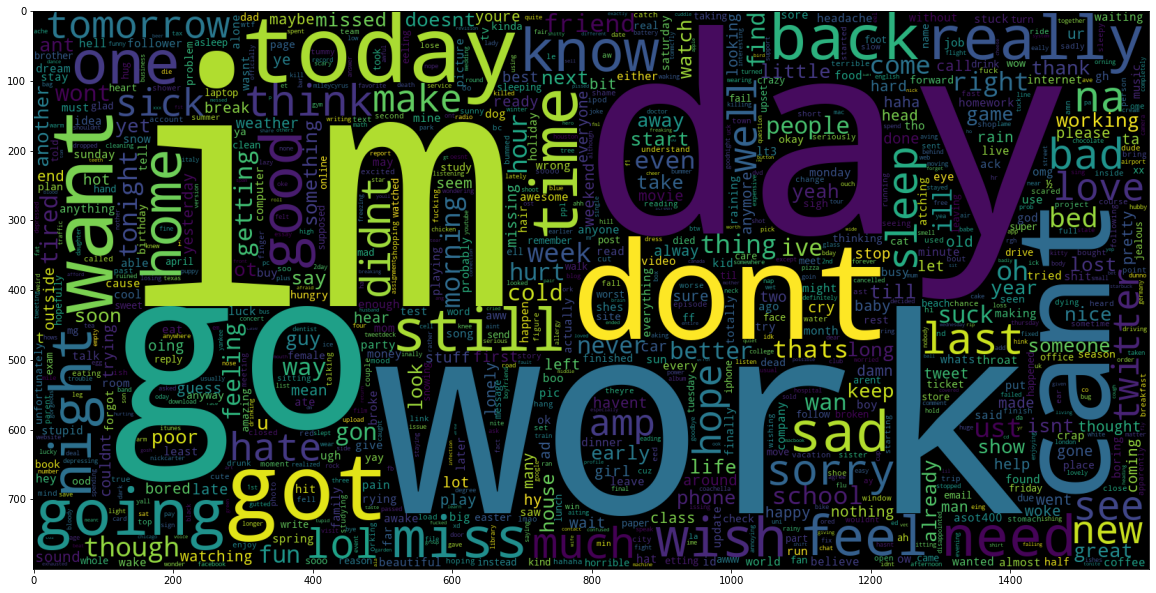

In [159]:
tweets_neg = tweets['text'][20000:]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(tweets_neg))
plt.imshow(wc)

#### Wordcloud of Positive sentiments

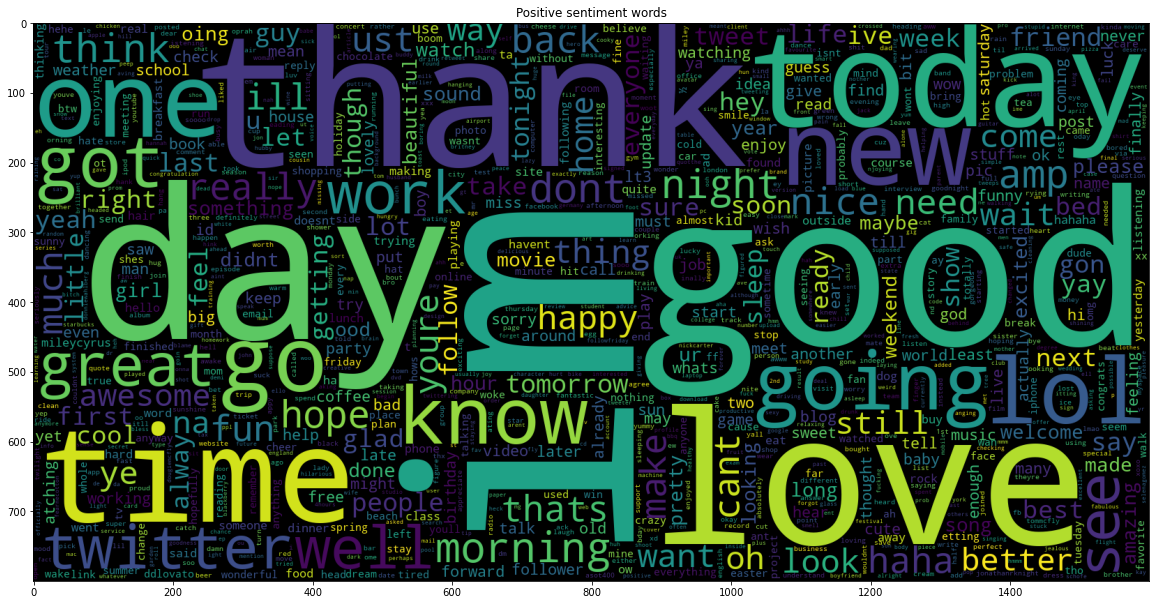

In [160]:
tweets_pos = tweets['text'][:20000]
plt.figure(figsize = (20,20))
plt.title("Positive sentiment words")
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(tweets_pos))
plt.imshow(wc)

#### Making the dataset ready for modeling and prediction

In [161]:
X = tweets['text'].values
y = tweets['target'].values

In [162]:
X.shape

(40000,)

In [163]:
y.shape

(40000,)

#### Split into train and test sets

In [164]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

#### Applying TFIDF Vectorisation.TFIDF refers to Term Frequency Inverse Document Frequency which refers to a scoring measure widely used to reflect how relevant a term is in a given document

vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [165]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    #Plot ROC-AUC Curve
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC CURVE')
    plt.legend(loc="lower right")
    plt.show()

#### Applying Random Forest

              precision    recall  f1-score   support

           0       0.69      0.62      0.65       991
           1       0.66      0.73      0.70      1009

    accuracy                           0.68      2000
   macro avg       0.68      0.68      0.67      2000
weighted avg       0.68      0.68      0.67      2000



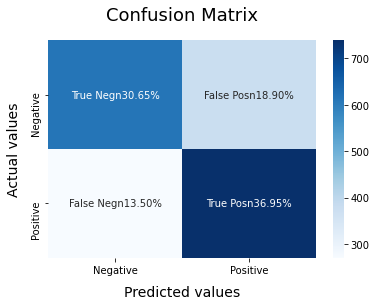

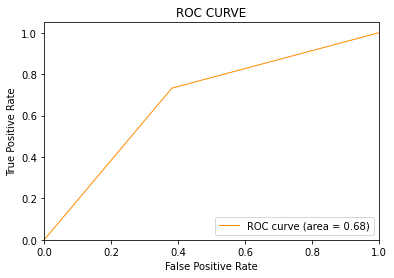

In [166]:
# define the stages of the pipeline
rf = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', max_depth=50)
pipeline = Pipeline(steps= [('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=500000)),
                            ('model', rf)])

pipeline.fit(X_train, y_train)
model_Evaluate(pipeline)

#### Applying Bernoulli Naive Bayes for text classification

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       991
           1       0.75      0.73      0.74      1009

    accuracy                           0.74      2000
   macro avg       0.74      0.74      0.74      2000
weighted avg       0.74      0.74      0.74      2000



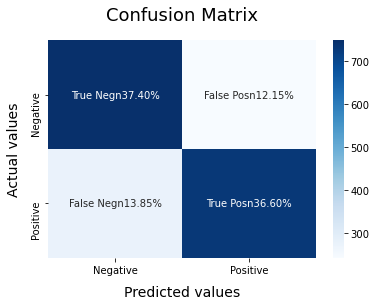

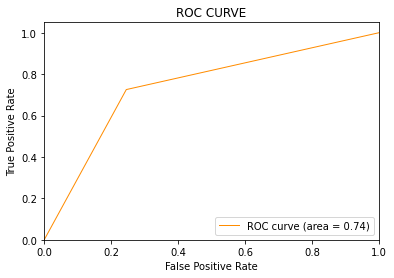

In [167]:
BNBmodel = BernoulliNB()
pipeline = Pipeline(steps= [('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=500000)),
                            ('model', BNBmodel)])
pipeline.fit(X_train, y_train)
model_Evaluate(pipeline)

#### Applying SVM

              precision    recall  f1-score   support

           0       0.73      0.78      0.76       991
           1       0.77      0.72      0.75      1009

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000



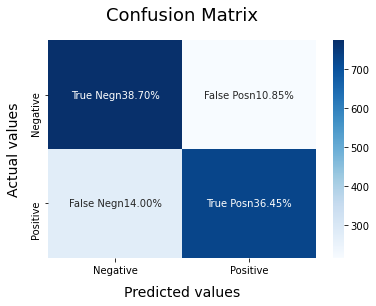

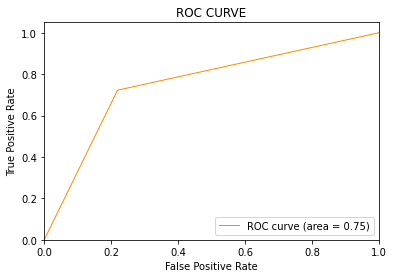

In [168]:
SVCmodel = LinearSVC()
pipeline = Pipeline(steps= [('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=500000)),
                            ('model', SVCmodel)])
pipeline.fit(X_train, y_train)
model_Evaluate(pipeline)

#### Applying Logistic Regression

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       991
           1       0.77      0.75      0.76      1009

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.76      0.76      2000



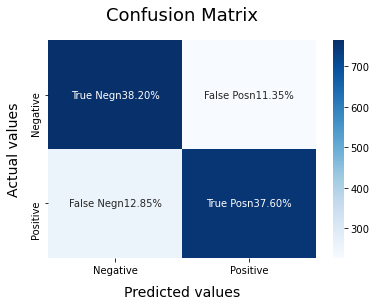

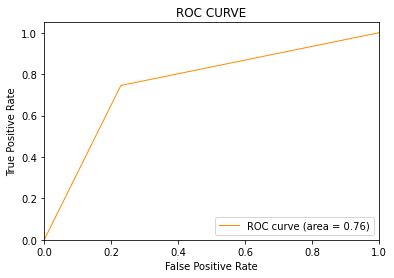

In [169]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
pipeline = Pipeline(steps= [('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=500000)),
                            ('model', LRmodel)])
pipeline.fit(X_train, y_train)
model_Evaluate(pipeline)

In [171]:
# dump the pipeline model
dump(pipeline, filename="Logistic_model.joblib")

['Logistic_model.joblib']

#### Conclusion
#### We have tried to do a sentiment analysis and use it for predicting sentiments.Eventhough Bernoulli's NB,SVM and Logistic Regression gives a close accuracy,Logistic Regression appears to be better at predictions.

In [172]:
X_test1=["I love ML","I hate arrogant people"]
y_pred2 = pipeline.predict(X_test1)

In [173]:
X_test1

['I love ML', 'I hate arrogant people']

In [174]:
y_pred2

array([1, 0], dtype=int64)